In [4]:
from SwarmEnvironment import *
from SwarmAgent import *
import numpy
# ------------------------------
# 4. Training Loop
# ------------------------------
numpy.random.seed(20)
manual_selected_device = "cpu"

env = SwarmEnv(n_agents=20, space_size=50)
env.set_random_goals()
agent = Agent(state_dim=9, action_dim=7, device="cpu")  # each agent observes 9 values


agent.gamma = 0.95 # q learning gamma, learning rate
agent.epsilon = 1.0 # action randomness 1 for fully random
agent.batch_size = 64

epsilon_decay = 0.9 # action randomness decay rate
epsilon_min = 0.05 # minimum epsilon

env.goal_reward = 2.0
env.collision_reward = -5.0
env.distance_reward_factor = 2.0

training_steps = 1000
episodes_length = 200

for episode in range(training_steps):
    observations = env.reset()
    total_reward = 0

    for step in range(episodes_length):
       # Batched GPU/MPS inference for all agents
       actions = agent.select_multiple_actions(observations)  # replaces the for-loop

        # Environment step (expects actions as a list or array)
       next_observations, rewards, done, _ = env.step(actions)

       # Store transitions for all agents
       for i in range(env.n_agents):
           agent.store(observations[i], actions[i], rewards[i], next_observations[i])

       # Train DQN
       agent.train_step()

       # Move to next step
       observations = next_observations
       total_reward += np.mean(rewards)

       # End early if environment finishes
       if done:
           break



    
    agent.update_target()
    agent.epsilon = max(epsilon_min, agent.epsilon * epsilon_decay)
    print(f"Episode {episode}, average total reward {total_reward:.2f}, eps {agent.epsilon:.2f}")

using device :  cpu
Episode 0, average total reward -0.07, eps 0.90
Episode 1, average total reward 18.84, eps 0.81
Episode 2, average total reward 25.94, eps 0.73
Episode 3, average total reward 36.71, eps 0.66
Episode 4, average total reward 47.05, eps 0.59
Episode 5, average total reward 48.08, eps 0.53
Episode 6, average total reward 45.14, eps 0.48
Episode 7, average total reward 55.40, eps 0.43
Episode 8, average total reward 50.64, eps 0.39
Episode 9, average total reward 57.56, eps 0.35
Episode 10, average total reward 66.14, eps 0.31
Episode 11, average total reward 60.39, eps 0.28
Episode 12, average total reward 60.50, eps 0.25
Episode 13, average total reward 59.40, eps 0.23
Episode 14, average total reward 60.56, eps 0.21
Episode 15, average total reward 59.32, eps 0.19
Episode 16, average total reward 63.65, eps 0.17
Episode 17, average total reward 62.11, eps 0.15
Episode 18, average total reward 60.11, eps 0.14
Episode 19, average total reward 59.73, eps 0.12
Episode 20

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

def visualize_swarm(agent, env, steps=50, save=False):
    obs = env.reset()
    positions_history = [env.positions.copy()]

    for _ in range(steps):
        actions = [agent.select_action(o) for o in obs]
        obs, _, done, _ = env.step(actions)
        positions_history.append(env.positions.copy())
        if done:
            break

    positions_history = np.array(positions_history)  # shape: [T, n_agents, 3]
    n_steps, n_agents, _ = positions_history.shape

    # Normalize goal shape
    goals = np.atleast_2d(env.goal)  # shape: (n_agents, 3) or (1, 3)
    if goals.shape[0] == 1:
        goals = np.repeat(goals, n_agents, axis=0)

    # Create 3D plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(0, env.space_size)
    ax.set_ylim(0, env.space_size)
    ax.set_zlim(0, env.space_size)
    ax.set_title("3D Swarm Movement (DQN)")

    scat = ax.scatter([], [], [], c='blue', s=50, label='Agents')
    goal_scat = ax.scatter(goals[:,0], goals[:,1], goals[:,2], c='red', s=100, marker='*', label='Goals')

    # Create one line per agent connecting to its goal
    lines = [ax.plot([], [], [], 'gray', linestyle='--', linewidth=1)[0] for _ in range(n_agents)]

    ax.legend()

    def init():
        scat._offsets3d = ([], [], [])
        for line in lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return [scat, *lines]

    def update(frame):
        pos = positions_history[frame]
        scat._offsets3d = (pos[:,0], pos[:,1], pos[:,2])

        for i, line in enumerate(lines):
            x = [pos[i, 0], goals[i, 0]]
            y = [pos[i, 1], goals[i, 1]]
            z = [pos[i, 2], goals[i, 2]]
            line.set_data(x, y)
            line.set_3d_properties(z)

        ax.set_title(f"3D Swarm Movement (Step {frame}/{n_steps})")
        return [scat, *lines]

    ani = animation.FuncAnimation(
        fig, update, frames=n_steps, init_func=init, interval=10, blit=False
    )

    if save:
        ani.save('swarm_simulation.gif', writer='pillow')
        print("Saved animation as swarm_simulation.gif")
    else:
        plt.show()


Saved animation as swarm_simulation.gif


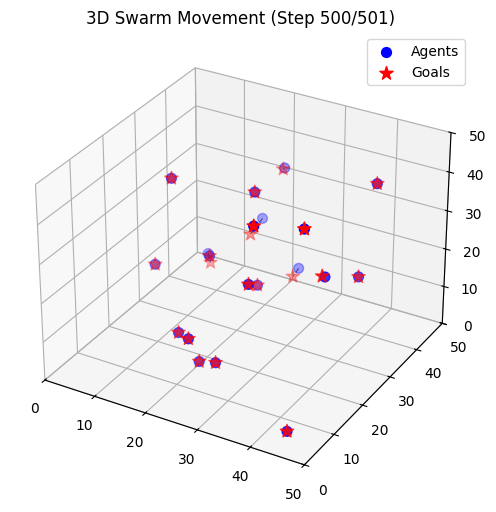

In [7]:
  visualize_swarm(agent, env, steps=500, save=True)